
Would you like to process
MYD04_L2.A2017332.0820.006.2017332194745.hdf

(Y/N)y
This is a 10km MODIS file. Here is some information: 

The valid range of values is:  -0.1  to  5.0 
The average is:  0.245 
The standard deviation is:  0.178
The range of latitude in this file is:  13.2711  to  34.0996 degrees 
The range of longitude in this file is:  60.7205  to  87.2177  degrees

Would you like to enter a slope and intercept for PM 2.5 calculation?y
Please enter a slope: 40
Please enter an intercept: 20

Would you like to create a map of this data? Please enter Y or N 
y


/Users/nipun/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/nipun/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


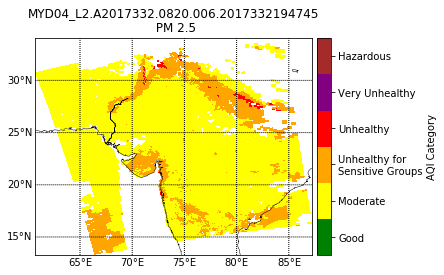


Would you like to save this map? Please enter Y or N 
y

All valid files have been processed.


In [2]:
#!/usr/bin/python
'''
Module: pm25_modis.py
==========================================================================================
Disclaimer: The code is for demonstration purposes only. Users are responsible to check for accuracy and revise to fit their objective.

Author: Justin Roberts-Pierel, 2015 
Organization: NASA ARSET
Purpose: To extract AOD data from a MODIS HDF4 file (or series of files), calculate PM 2.5 from the data, and create a map of the results

See the README associated with this module for more information.
==========================================================================================
'''

#import necessary modules
from pyhdf import SD
import numpy as np
import sys
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

#This uses the file "fileList.txt", containing the list of files, in order to read the files
try:
    fileList=open('Small-MODIS_fileList.txt','r')
except:
    print('Did not find a text file containing file names (perhaps name does not match)')
    sys.exit()

#loops through all files listed in the text file
for FILE_NAME in fileList:
    FILE_NAME=FILE_NAME.strip()
    user_input=input('\nWould you like to process\n' + FILE_NAME + '\n\n(Y/N)')
    if(user_input == 'N' or user_input == 'n'):
        continue
    else:
        if '3K' in FILE_NAME:#then this is a 3km MODIS file
            print('This is a 3km MODIS file. Here is some information: ')
            SDS_NAME='Optical_Depth_Land_And_Ocean' # The name of the sds to read
        elif 'L2' in FILE_NAME: #Same as above but for 10km MODIS file
            print('This is a 10km MODIS file. Here is some information: ')
            SDS_NAME='AOD_550_Dark_Target_Deep_Blue_Combined'
        else:#if it is neither 3km nor 10km, then this will skip the rest of this loop iteration
            print('The file :',FILE_NAME, ' is not a valid MODIS file (Or is named incorrectly). \n')
            continue
        try:
            # open the hdf file for reading
            hdf=SD.SD(FILE_NAME)
        except:
            print('Unable to open file: \n' + FILE_NAME + '\n Skipping...')
            continue

        # Get lat and lon info
        lat = hdf.select('Latitude')
        latitude = lat[:]
        min_lat=latitude.min()
        max_lat=latitude.max()
        lon = hdf.select('Longitude')
        longitude = lon[:]
        min_lon=longitude.min()
        max_lon=longitude.max()

        #get AOD SDS, or exit if it doesn't find the SDS in the file
        try:
            sds=hdf.select(SDS_NAME)
        except:
            try:
                sds=hdf.select('Optical_Depth_Land_And_Ocean')
            except:
                print('Sorry, your MODIS hdf file does not contain the SDS:',SDS_NAME,'. Please try again with the correct file type.')
                continue
        #get scale factor for AOD SDS
        attributes=sds.attributes()
        scale_factor=attributes['scale_factor']
        #get valid range for AOD SDS
        range=sds.getrange()
        min_range=min(range)
        max_range=max(range)

        #get SDS data
        data=sds.get()
        #get data within valid range
        valid_data=data.ravel()
        valid_data=[x for x in valid_data if x>=min_range]
        valid_data=[x for x in valid_data if x<=max_range]
        valid_data=np.asarray(valid_data)
        #scale the valid data
        valid_data=valid_data*scale_factor
        #find the average
        average=sum(valid_data)/len(valid_data)
        #find the standard deviation
        stdev=np.std(valid_data)
        #print information
        print('\nThe valid range of values is: ',round(min_range*scale_factor,3), ' to ',round(max_range*scale_factor,3),'\nThe average is: ',round(average,3),'\nThe standard deviation is: ',round(stdev,3))
        print('The range of latitude in this file is: ',min_lat,' to ',max_lat, 'degrees \nThe range of longitude in this file is: ',min_lon, ' to ',max_lon,' degrees')


        #asks user if they want to set PM2.5 calculation parameters
        user_input=input('\nWould you like to enter a slope and intercept for PM 2.5 calculation?')
        if user_input == 'Y' or user_input == 'y': 
            slope=input('Please enter a slope: ')
            intercept=input('Please enter an intercept: ')
        else:
            #if not, choose the following:
            slope=29.4
            intercept=8.8
        valid_data=data*scale_factor
        pm25=float(slope)*valid_data+float(intercept)



        #Asks user if they would like to see a map
        is_map=input('\nWould you like to create a map of this data? Please enter Y or N \n')
        #if user would like a map, view it
        if is_map == 'Y' or is_map == 'y':
            #turn fillvalues to NaN
            data=pm25.astype(float)
            data[np.logical_and(data>=0,data <= 12)]=0
            data[np.logical_and(data>12,data <= 35.4)]=1
            data[np.logical_and(data>35.4,data <= 55.4)]=2
            data[np.logical_and(data>55.4,data <= 150.4)]=3
            data[np.logical_and(data>150.4,data <= 250.4)]=4
            data[data>250.4]=5
            data[data < 0] = np.nan
            #create the map
            data = np.ma.masked_array(data, np.isnan(data))
            m = Basemap(projection='cyl', resolution='l', llcrnrlat=min_lat, urcrnrlat = max_lat, llcrnrlon=min_lon, urcrnrlon = max_lon)
            m.drawcoastlines(linewidth=0.5)
            m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
            m.drawmeridians(np.arange(-180., 181., 5.), labels=[0, 0, 0, 1])
            x, y = m(longitude, latitude)
            my_cmap=LinearSegmentedColormap.from_list('mycmap', ['green','yellow','orange','red','purple','brown'],6)
            m.pcolormesh(x, y, data,cmap=my_cmap)
            plt.clim(0,6)
            #create colorbar
            cb = m.colorbar()
            cb.set_label('AQI Category')
            cb.set_ticks([.5, 1.5,2.5,3.5,4.5,5.5])  # force there to be only 7 ticks
            cb.set_ticklabels(['Good', 'Moderate', 'Unhealthy for \nSensitive Groups','Unhealthy','Very Unhealthy','Hazardous'])  # put text labels on them

            #title the plot
            plotTitle=FILE_NAME[:-4]
            plt.title('{0}\n {1}'.format(plotTitle, 'PM 2.5'))
            fig = plt.gcf()
            # Show the plot window.
            plt.show()
            #once you close the map it asks if you'd like to save it
            is_save=str(input('\nWould you like to save this map? Please enter Y or N \n'))
            if is_save == 'Y' or is_save == 'y':
                #saves as a png if the user would like5
                pngfile = '{0}.png'.format(plotTitle)
                fig.savefig(pngfile)
    print('\nAll valid files have been processed.')
